In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential

In [2]:
custom_stock = pd.read_csv('../ETT-small/price_FCHI.csv')
# SZ_stock = pd.read_csv('Autoformer/ETT-small/price_SZ.csv')
print(custom_stock.shape)
print(custom_stock.isnull().any())
custom_stock.tail()
# SZ_stock.head()
# prediction = custom_stock.iloc[-500:]
# print(prediction.shape)
# prediction.to_csv('Autoformer/ETT-small/price_prediction.csv',index = False)

(2298, 8)
date            False
turnoverVol     False
CHG             False
CHGPct          False
openIndex       False
highestIndex    False
lowestIndex     False
closeIndex      False
dtype: bool


,date,turnoverVol,CHG,CHGPct,openIndex,highestIndex,lowestIndex,closeIndex
2293,2018-12-20,120847000.0,-84.99,-1.7790,4709.75,4719.61,4685.61,4692.46
2294,2018-12-21,187129800.0,1.92,0.0409,4672.77,4696.18,4628.24,4694.38
2295,2018-12-24,24595900.0,-67.99,-1.4483,4650.42,4664.20,4622.03,4626.39
2296,2018-12-27,89451800.0,-27.78,-0.6005,4689.20,4692.43,4555.99,4598.61
2297,2018-12-28,67583000.0,80.13,1.7425,4641.05,4700.49,4623.97,4678.74


In [3]:
# SZ_stock.to_csv('price_SZ_new.csv',index=False)

In [4]:
custom_stock = custom_stock.drop(custom_stock[(custom_stock['CHG']==0) | (custom_stock['CHGPct']==0)].index) #删除x小于0.01或大于10的行
custom_stock.shape

(2298, 8)

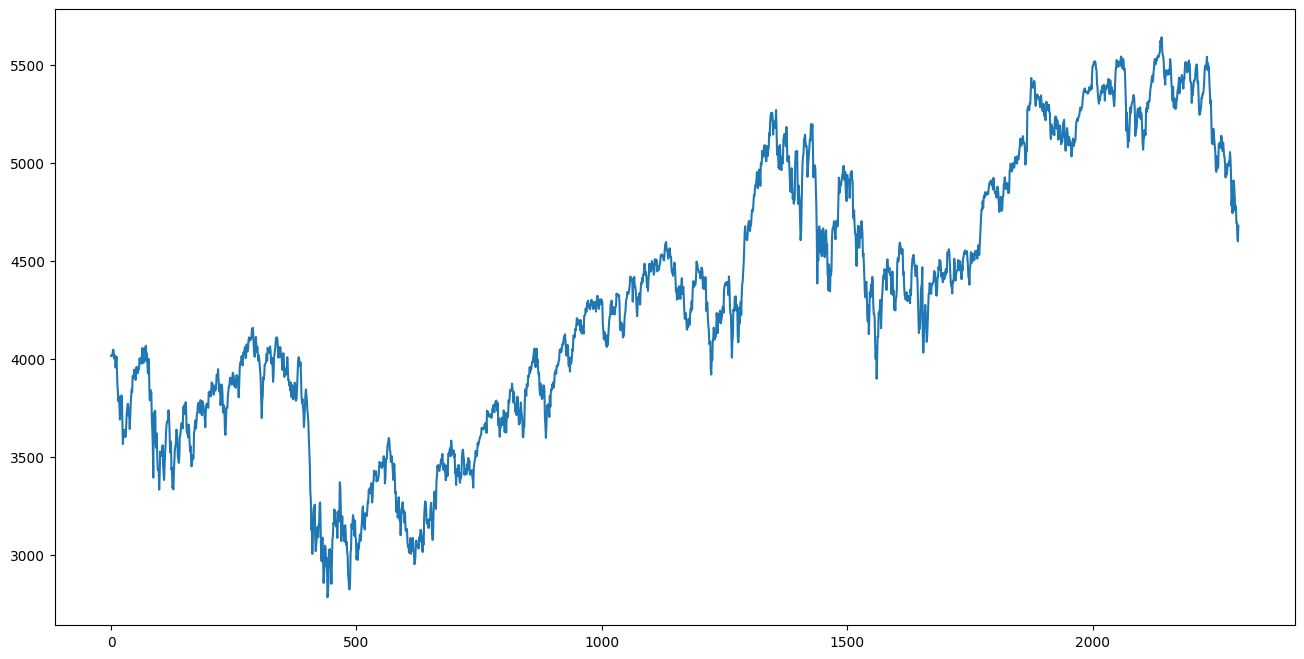

In [5]:
import matplotlib.pyplot as plt
# import seaborn as sns
plt.figure(figsize=(16, 8))
plt.plot(custom_stock['closeIndex'])
plt.show()

In [26]:
# 时间点长度
from sklearn.preprocessing import StandardScaler
time_stamp = 5
# 划分训练集与验证集
custom_stock = custom_stock[['CHG','CHGPct','openIndex','highestIndex','lowestIndex','closeIndex']]  #  'Volume'

# custom_stock = custom_stock[['turnoverVol','turnoverValue','CHG','CHGPct','openIndex','highestIndex','lowestIndex','closeIndex']]  #  'Volume'
total_len = custom_stock.shape[0]
# valid_len = 1000
valid_len = (int) (total_len*0.2)
train_len = total_len - valid_len


train = custom_stock[0:train_len]

valid = custom_stock[train_len-time_stamp-1:-1]

# 归一化

scaler = StandardScaler()
scaled_data = scaler.fit(train)
global mean 
global std
std = scaler.scale_[-1]
mean = scaler.mean_[-1]
print(std,mean)
scaled_data = scaler.transform(train)
x_train, y_train = [], []
# print(scaled_data)

# 训练集
print(scaled_data.shape)
print(scaled_data[1, -1])
for i in range(time_stamp, len(train)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, -1])

x_train, y_train = np.array(x_train), np.array(y_train)

# 验证集
scaled_data = scaler.transform(valid)
# print(scaled_data)
x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)):
    x_valid.append(scaled_data[i - time_stamp:i])
    y_valid.append(scaled_data[i, -1])

x_valid, y_valid = np.array(x_valid), np.array(y_valid)

print(x_train.shape)
print(x_valid.shape)
# print(y_valid)
train.head()

382.3092306775678 1664.2605341777041
(1812, 6)
-1.3804022289558326
(1807, 5, 6)
(452, 5, 6)


,CHG,CHGPct,openIndex,highestIndex,lowestIndex,closeIndex
0,17.89001,1.6043,1116.56006,1133.87000,1116.56006,1132.98999
1,3.53003,0.3116,1132.66003,1136.63000,1129.66003,1136.52002
2,0.61999,0.0546,1135.70996,1139.18994,1133.94995,1137.14001
3,4.54993,0.4001,1136.27002,1142.45996,1131.31995,1141.68994
4,3.29004,0.2882,1140.52002,1145.39001,1136.21997,1144.97998


In [21]:
#RC model
import keras
import  tensorflow as tf
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D,Activation,Dropout,RNN
from keras_bert import AdamWarmup, calc_train_steps
epochs = 100
batch_size = 64

class ReservoirLayer(tf.keras.layers.Layer):
    def __init__(self, num_units, **kwargs):
        super(ReservoirLayer, self).__init__(**kwargs)
        self.num_units = num_units

    def build(self, input_shape):
        self.reservoir_weights = self.add_weight(
            shape=(input_shape[-1], self.num_units),
            initializer="random_normal",
            trainable=False,
        )
        self.reservoir_bias = self.add_weight(
            shape=(self.num_units,),
            initializer="zeros",
            trainable=False,
        )

    def call(self, inputs):
        reservoir_output = tf.matmul(inputs, self.reservoir_weights) + self.reservoir_bias
        reservoir_output = tf.nn.tanh(reservoir_output)
        return reservoir_output


# Create the Reservoir Computing model
model = tf.keras.Sequential([
    ReservoirLayer(num_units=128),
    keras.layers.SimpleRNN(units=64,activation='relu'),
    Dense(16),
    Dense(1)

])
callbacks_list = [
    # 目标指标不再有改善了，就可以提前终止
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,
                                         verbose=0,mode='min',baseline=None,
                                         restore_best_weights=True),
    # 保存模型

]
EStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,
                                         verbose=0,mode='min', baseline=None,
                                         restore_best_weights=True
                                         )

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=keras.losses.MAE, optimizer=adam, metrics=["mae","mse"])
model.fit(x_train, y_train,
                 epochs=epochs,validation_data=(x_valid, y_valid),
                 batch_size=batch_size, verbose=1,
                callbacks=[callbacks_list])
# loss= model.evaluate(x_valid, u, verbose=0)
# print("loss",loss)
# new_model = tf.keras.models.load_model('test.h5')

print(y_valid[0])


Epoch 1/100
29/29 [==============================] - 1s 7ms/step - loss: 0.2238 - mae: 0.2238 - mse: 0.1374 - val_loss: 0.1652 - val_mae: 0.1652 - val_mse: 0.0374
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0482 - mae: 0.0482 - mse: 0.0041 - val_loss: 0.1227 - val_mae: 0.1227 - val_mse: 0.0220
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0362 - mae: 0.0362 - mse: 0.0024 - val_loss: 0.0772 - val_mae: 0.0772 - val_mse: 0.0103
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0325 - mae: 0.0325 - mse: 0.0020 - val_loss: 0.1533 - val_mae: 0.1533 - val_mse: 0.0303
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0330 - mae: 0.0330 - mse: 0.0019 - val_loss: 0.0982 - val_mae: 0.0982 - val_mse: 0.0143
Epoch 6/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0324 - mae: 0.0324 - mse: 0.0019 - val_loss: 0.1500 - val_mae: 0.1500 - val_mse: 0.0290
Epoch 7/100
29/29 [===

In [8]:
# 超参数
#CNN
import keras
import tensorflow.keras.backend as K
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D,Activation,Dropout,RNN
import tensorflow as tf
from tensorflow.keras.layers import Layer
from keras_bert import AdamWarmup, calc_train_steps
epochs = 100
batch_size = 64


def mean_pred(y_true, y_pred):
    return K.mean(y_pred)
def R2(pred, true):
    return 1 - (np.sum((true-pred)**2)) / (np.sum((true-true.mean())**2))

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        # W_regularizer: 权重上的正则化
        # b_regularizer: 偏置项的正则化
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        # W_constraint: 权重上的约束项
        # b_constraint: 偏置上的约束项
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
                    self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
            
        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None
    
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        
        if self.bias:
            eij += self.b
            
        eij = K.tanh(eij)
        
        a = K.exp(eij)
        
        '''
        keras.backend.cast(x, dtype): 将张量转换到不同的 dtype 并返回
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())
            
        '''
        keras.backend.epsilon(): 返回浮点数
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon()   , K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

class CustomEarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.model.set_weights(self.best_weights)
            print("learning_rate: ",self.learning_rate)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# print(y_valid)

# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
model.add(Conv1D(filters=64,kernel_size=1,activation='tanh'))
# model.add(Dropout(0.5))
model.add(MaxPooling1D(1))
# model.add(Activation('relu'))
# model.add(LSTM(units=64, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1],activation='tanh'))
# model.add(keras.layers.Bidirectional(LSTM(units=64,return_sequences=False,activation='tanh')))
# model.add(keras.layers.LSTM(units=164,return_sequences=False,activation='tanh'))
# model.add(keras.layers.SimpleRNN(units=64,activation='tanh'))
# model.add(Attention(5))
# model.add(Dropout(0.5))
model.add(Dense(1))
callbacks_list = [
    # 目标指标不再有改善了，就可以提前终止
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,
                                         verbose=0,mode='min',baseline=None,
                                         restore_best_weights=True),
    # 保存模型
    tf.keras.callbacks.ModelCheckpoint(
    filepath = 'test.h5', # 文件路径
    monitor='val_loss', # 如果val_loss 没有改善就不覆盖
    save_best_only=True) # 保持最佳模型
    
]
EStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,
                                         verbose=0,mode='min', baseline=None,
                                         restore_best_weights=True
                                         )
Learn_rate_adjust = tf.keras.callbacks.LearningRateScheduler(scheduler) 

total_steps, warmup_steps = calc_train_steps(
    num_example=x_train.shape[0],
    batch_size=batch_size,
    epochs=epochs,
    warmup_proportion=0.1,
)
# optimizer_ad = AdamWarmup(total_steps, warmup_steps, learning_rate=1e-3, min_lr=1e-7)
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=keras.losses.MAE, optimizer=adam, metrics=["mae","mse"])
hist = model.fit(x_train, y_train, 
                 epochs=epochs,validation_data=(x_valid, y_valid), 
                 batch_size=batch_size, verbose=1,
                callbacks=[callbacks_list])
# loss= model.evaluate(x_valid, u, verbose=0)
# print("loss",loss)
new_model = tf.keras.models.load_model('test.h5')

print(y_valid[0])

Epoch 1/100
29/29 [==============================] - 0s 5ms/step - loss: 0.8309 - mae: 0.8309 - mse: 1.0054 - val_loss: 2.2900 - val_mae: 2.2900 - val_mse: 5.3613
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 0.8308 - mae: 0.8308 - mse: 1.0056 - val_loss: 2.1157 - val_mae: 2.1157 - val_mse: 4.5889
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 0.8308 - mae: 0.8308 - mse: 1.0050 - val_loss: 2.2092 - val_mae: 2.2092 - val_mse: 4.9953
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 0.8303 - mae: 0.8303 - mse: 1.0038 - val_loss: 2.2006 - val_mae: 2.2006 - val_mse: 4.9577
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 0.8302 - mae: 0.8302 - mse: 1.0044 - val_loss: 2.1575 - val_mae: 2.1575 - val_mse: 4.7682
Epoch 6/100
29/29 [==============================] - 0s 2ms/step - loss: 0.8301 - mae: 0.8301 - mse: 1.0042 - val_loss: 2.2031 - val_mae: 2.2031 - val_mse: 4.9689
Epoch 7/100
29/29 [===

In [33]:
# 超参数
#RNN
import keras
import tensorflow.keras.backend as K
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D,Activation,Dropout,RNN
import tensorflow as tf
from tensorflow.keras.layers import Layer
from keras_bert import AdamWarmup, calc_train_steps
epochs = 100
batch_size = 64


def mean_pred(y_true, y_pred):
    return K.mean(y_pred)
def R2(pred, true):
    return 1 - (np.sum((true-pred)**2)) / (np.sum((true-true.mean())**2))

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        # W_regularizer: 权重上的正则化
        # b_regularizer: 偏置项的正则化
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        # W_constraint: 权重上的约束项
        # b_constraint: 偏置上的约束项
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
                    self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
            
        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None
    
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        
        if self.bias:
            eij += self.b
            
        eij = K.tanh(eij)
        
        a = K.exp(eij)
        
        '''
        keras.backend.cast(x, dtype): 将张量转换到不同的 dtype 并返回
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())
            
        '''
        keras.backend.epsilon(): 返回浮点数
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon()   , K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

class CustomEarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.model.set_weights(self.best_weights)
            print("learning_rate: ",self.learning_rate)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# print(y_valid)

# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
# model.add(Conv1D(filters=64,kernel_size=1,activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(1))
# model.add(Activation('relu'))
# model.add(LSTM(units=64, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1],activation='tanh'))
# model.add(keras.layers.Bidirectional(LSTM(units=64,return_sequences=False,activation='tanh')))
# model.add(keras.layers.LSTM(units=164,return_sequences=False,activation='tanh'))
model.add(keras.layers.SimpleRNN(units=64,activation='relu'))
model.add(Dense(16))
# model.add(Attention(5))
# model.add(Dropout(0.5))
model.add(Dense(1))
callbacks_list = [
    # 目标指标不再有改善了，就可以提前终止
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,
                                         verbose=0,mode='min',baseline=None,
                                         restore_best_weights=True),
    # 保存模型
    tf.keras.callbacks.ModelCheckpoint(
    filepath = 'test.h5', # 文件路径
    monitor='val_loss', # 如果val_loss 没有改善就不覆盖
    save_best_only=True) # 保持最佳模型
    
]
EStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,
                                         verbose=0,mode='min', baseline=None,
                                         restore_best_weights=True
                                         )
Learn_rate_adjust = tf.keras.callbacks.LearningRateScheduler(scheduler) 

total_steps, warmup_steps = calc_train_steps(
    num_example=x_train.shape[0],
    batch_size=batch_size,
    epochs=epochs,
    warmup_proportion=0.1,
)
# optimizer_ad = AdamWarmup(total_steps, warmup_steps, learning_rate=1e-3, min_lr=1e-7)
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=keras.losses.MAE, optimizer=adam, metrics=["mae","mse"])
hist = model.fit(x_train, y_train, 
                 epochs=epochs,validation_data=(x_valid, y_valid), 
                 batch_size=batch_size, verbose=1,
                callbacks=[callbacks_list])
# loss= model.evaluate(x_valid, u, verbose=0)
# print("loss",loss)
new_model = tf.keras.models.load_model('test.h5')

print(y_valid[0])

Epoch 1/100
29/29 [==============================] - 1s 7ms/step - loss: 0.2432 - mae: 0.2432 - mse: 0.1507 - val_loss: 2625.6917 - val_mae: 2625.6917 - val_mse: 6921098.0000
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0642 - mae: 0.0642 - mse: 0.0085 - val_loss: 2625.7756 - val_mae: 2625.7756 - val_mse: 6921546.0000
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0455 - mae: 0.0455 - mse: 0.0040 - val_loss: 2625.7830 - val_mae: 2625.7830 - val_mse: 6921582.5000
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0402 - mae: 0.0402 - mse: 0.0031 - val_loss: 2625.7556 - val_mae: 2625.7556 - val_mse: 6921435.0000
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0377 - mae: 0.0377 - mse: 0.0027 - val_loss: 2625.8870 - val_mae: 2625.8870 - val_mse: 6922135.0000
Epoch 6/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0394 - mae: 0.0394 - mse: 0.0029 - val_loss: 2625.

In [8]:
print(hist.history['loss'])

[0.2061951905488968, 0.04709579050540924, 0.040935125201940536, 0.03937966004014015, 0.037464432418346405, 0.03793541342020035, 0.035842444747686386, 0.03417360782623291, 0.036062419414520264, 0.03329167515039444, 0.03403981775045395, 0.035778436809778214, 0.031034080311655998, 0.031488947570323944, 0.03087908774614334, 0.03134096786379814, 0.0315997451543808, 0.031002318486571312, 0.031114695593714714, 0.03069830685853958, 0.02973872795701027, 0.03073178045451641, 0.030819838866591454, 0.03029222972691059, 0.031177913770079613, 0.030957425013184547, 0.029788633808493614, 0.03076297603547573, 0.029307352378964424, 0.029489781707525253, 0.03048798441886902, 0.029719509184360504, 0.02938377484679222, 0.029254918918013573, 0.029393212869763374, 0.030182354152202606, 0.028721433132886887, 0.03156566992402077, 0.028859708458185196, 0.029996734112501144, 0.03185740113258362, 0.02956295572221279, 0.028301188722252846, 0.029495390132069588, 0.028525380417704582, 0.029217112809419632, 0.0291231

In [18]:
# 超参数
# LSTM
import keras
import tensorflow.keras.backend as K
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D,Activation,Dropout
import tensorflow as tf
from tensorflow.keras.layers import Layer
from keras_bert import AdamWarmup, calc_train_steps
epochs = 100
batch_size = 64


def mean_pred(y_true, y_pred):
    return K.mean(y_pred)
def R2(pred, true):
    return 1 - (np.sum((true-pred)**2)) / (np.sum((true-true.mean())**2))

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        # W_regularizer: 权重上的正则化
        # b_regularizer: 偏置项的正则化
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        # W_constraint: 权重上的约束项
        # b_constraint: 偏置上的约束项
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
                    self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
            
        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None
    
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        
        if self.bias:
            eij += self.b
            
        eij = K.tanh(eij)
        
        a = K.exp(eij)
        
        '''
        keras.backend.cast(x, dtype): 将张量转换到不同的 dtype 并返回
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())
            
        '''
        keras.backend.epsilon(): 返回浮点数
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon()   , K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

class CustomEarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.model.set_weights(self.best_weights)
            print("learning_rate: ",self.learning_rate)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# print(y_valid)

# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
# model.add(Conv1D(filters=64,kernel_size=1,activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(1))
# model.add(Activation('relu'))
# model.add(LSTM(units=64, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1],activation='tanh'))
# model.add(keras.layers.Bidirectional(LSTM(units=64,return_sequences=False,activation='tanh')))
model.add(keras.layers.LSTM(units=64,return_sequences=False,activation='tanh'))
# model.add(Attention(5))
# model.add(Dropout(0.5))
model.add(Dense(1))
EStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=25,
                                         verbose=0,mode='min',baseline=None,
                                         restore_best_weights=True)
Learn_rate_adjust = tf.keras.callbacks.LearningRateScheduler(scheduler) 
callbacks_list = [
    # 目标指标不再有改善了，就可以提前终止
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=25,
                                         verbose=0,mode='min',baseline=None,
                                         restore_best_weights=True),
    # 保存模型
    tf.keras.callbacks.ModelCheckpoint(
    filepath = 'test.h5', # 文件路径
    monitor='val_loss', # 如果val_loss 没有改善就不覆盖
    save_best_only=True) # 保持最佳模型
    
]
total_steps, warmup_steps = calc_train_steps(
    num_example=x_train.shape[0],
    batch_size=batch_size,
    epochs=epochs,
    warmup_proportion=0.1,
)
# optimizer_ad = AdamWarmup(total_steps, warmup_steps, learning_rate=1e-3, min_lr=1e-7)
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=keras.losses.MAE, optimizer=adam, metrics=["mae","mse"])
hist = model.fit(x_train, y_train, 
                 epochs=epochs,validation_data=(x_valid, y_valid), 
                 batch_size=batch_size, verbose=1,
                callbacks=[callbacks_list])
# loss= model.evaluate(x_valid, u, verbose=0)
# print("loss",loss)

new_model = tf.keras.models.load_model('test.h5')
print(y_valid[0])

Epoch 1/100
8/8 [==============================] - 2s 85ms/step - loss: 0.8274 - mae: 0.8274 - mse: 1.1359 - val_loss: 2.6753 - val_mae: 2.6753 - val_mse: 10.1368
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.4923 - mae: 0.4923 - mse: 0.4441 - val_loss: 1.9202 - val_mae: 1.9202 - val_mse: 6.0178
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.2522 - mae: 0.2522 - mse: 0.1177 - val_loss: 1.4810 - val_mae: 1.4810 - val_mse: 4.2048
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.2446 - mae: 0.2446 - mse: 0.1005 - val_loss: 1.6291 - val_mae: 1.6291 - val_mse: 4.8358
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1818 - mae: 0.1818 - mse: 0.0572 - val_loss: 1.6588 - val_mae: 1.6588 - val_mse: 4.9933
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1705 - mae: 0.1705 - mse: 0.0512 - val_loss: 1.5272 - val_mae: 1.5272 - val_mse: 4.2754
Epoch 7/100
8/8 [=============

In [88]:
# 超参数
# BiLSTM
import keras
import tensorflow.keras.backend as K
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D,Activation,Dropout
import tensorflow as tf
from tensorflow.keras.layers import Layer
from keras_bert import AdamWarmup, calc_train_steps
epochs = 100
batch_size = 64

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)
def R2(pred, true):
    return 1 - (np.sum((true-pred)**2)) / (np.sum((true-true.mean())**2))

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        # W_regularizer: 权重上的正则化
        # b_regularizer: 偏置项的正则化
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        # W_constraint: 权重上的约束项
        # b_constraint: 偏置上的约束项
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
                    self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
            
        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None
    
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        
        if self.bias:
            eij += self.b
            
        eij = K.tanh(eij)
        
        a = K.exp(eij)
        
        '''
        keras.backend.cast(x, dtype): 将张量转换到不同的 dtype 并返回
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())
            
        '''
        keras.backend.epsilon(): 返回浮点数
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon()   , K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

class CustomEarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.model.set_weights(self.best_weights)
            print("learning_rate: ",self.learning_rate)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# print(y_valid)

# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
# model.add(Conv1D(filters=64,kernel_size=1,activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(1))
# model.add(Activation('relu'))
# model.add(LSTM(units=64, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1],activation='tanh'))
model.add(keras.layers.Bidirectional(LSTM(units=64,return_sequences=False,activation='tanh')))
# model.add(keras.layers.LSTM(units=64,return_sequences=False,activation='tanh'))
# model.add(Attention(5))
# model.add(Dropout(0.5))
model.add(Dense(1))
EStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=25,
                                         verbose=0,mode='min',baseline=None,
                                         restore_best_weights=True)
Learn_rate_adjust = tf.keras.callbacks.LearningRateScheduler(scheduler) 
callbacks_list = [
    # 目标指标不再有改善了，就可以提前终止
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=25,
                                         verbose=0,mode='min',baseline=None,
                                         restore_best_weights=True),
    # 保存模型
    tf.keras.callbacks.ModelCheckpoint(
    filepath = 'test.h5', # 文件路径
    monitor='val_loss', # 如果val_loss 没有改善就不覆盖
    save_best_only=True) # 保持最佳模型
    
]
total_steps, warmup_steps = calc_train_steps(
    num_example=x_train.shape[0],
    batch_size=batch_size,
    epochs=epochs,
    warmup_proportion=0.1,
)
optimizer_ad = AdamWarmup(total_steps, warmup_steps, learning_rate=1e-3, min_lr=1e-7)
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=keras.losses.MAE, optimizer=adam, metrics=["mae","mse"])
hist = model.fit(x_train, y_train, 
                 epochs=epochs,validation_data=(x_valid, y_valid), 
                 batch_size=batch_size, verbose=1,
                callbacks=[callbacks_list])
# loss= model.evaluate(x_valid, u, verbose=0)
# print("loss",loss)

new_model = tf.keras.models.load_model('test.h5')
print(y_valid[0])

Epoch 1/100
96/96 [==============================] - 5s 18ms/step - loss: 0.1286 - mae: 0.1286 - mse: 0.0909 - val_loss: 0.0417 - val_mae: 0.0417 - val_mse: 0.0030
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0286 - mae: 0.0286 - mse: 0.0024 - val_loss: 0.0385 - val_mae: 0.0385 - val_mse: 0.0025
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0277 - mae: 0.0277 - mse: 0.0022 - val_loss: 0.0284 - val_mae: 0.0284 - val_mse: 0.0015
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0272 - mae: 0.0272 - mse: 0.0020 - val_loss: 0.0390 - val_mae: 0.0390 - val_mse: 0.0023
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0275 - mae: 0.0275 - mse: 0.0020 - val_loss: 0.0475 - val_mae: 0.0475 - val_mse: 0.0040
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0271 - mae: 0.0271 - mse: 0.0021 - val_loss: 0.0262 - val_mae: 0.0262 - val_mse: 0.0018
Epoch 7/100
96/9

Epoch 51/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0247 - mae: 0.0247 - mse: 0.0017 - val_loss: 0.0245 - val_mae: 0.0245 - val_mse: 0.0011
Epoch 52/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0245 - mae: 0.0245 - mse: 0.0017 - val_loss: 0.0304 - val_mae: 0.0304 - val_mse: 0.0015
Epoch 53/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0243 - mae: 0.0243 - mse: 0.0017 - val_loss: 0.0369 - val_mae: 0.0369 - val_mse: 0.0023
Epoch 54/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0244 - mae: 0.0244 - mse: 0.0017 - val_loss: 0.0239 - val_mae: 0.0239 - val_mse: 0.0012
Epoch 55/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0256 - mae: 0.0256 - mse: 0.0017 - val_loss: 0.0301 - val_mae: 0.0301 - val_mse: 0.0017
Epoch 56/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0243 - mae: 0.0243 - mse: 0.0017 - val_loss: 0.0309 - val_mae: 0.0309 - val_mse: 0.0017
Epoch 57/100

In [74]:
# 超参数
# CNN-LSTM
import keras
import tensorflow.keras.backend as K
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D,Activation,Dropout
import tensorflow as tf
from tensorflow.keras.layers import Layer
from keras_bert import AdamWarmup, calc_train_steps
epochs = 150
batch_size = 64

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)
def R2(pred, true):
    return 1 - (np.sum((true-pred)**2)) / (np.sum((true-true.mean())**2))

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        # W_regularizer: 权重上的正则化
        # b_regularizer: 偏置项的正则化
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        # W_constraint: 权重上的约束项
        # b_constraint: 偏置上的约束项
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
                    self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
            
        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None
    
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        
        if self.bias:
            eij += self.b
            
        eij = K.tanh(eij)
        
        a = K.exp(eij)
        
        '''
        keras.backend.cast(x, dtype): 将张量转换到不同的 dtype 并返回
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())
            
        '''
        keras.backend.epsilon(): 返回浮点数
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon()   , K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

class CustomEarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.model.set_weights(self.best_weights)
            print("learning_rate: ",self.learning_rate)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# print(y_valid)
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
model.add(Conv1D(filters=64,kernel_size=1,activation='relu'))
# model.add(Dropout(0.5))
model.add(MaxPooling1D(1))
model.add(Activation('relu'))
# model.add(LSTM(units=64, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1],activation='tanh'))
# model.add(keras.layers.Bidirectional(LSTM(units=64,return_sequences=False,activation='tanh')))
model.add(keras.layers.LSTM(units=64,return_sequences=False,activation='tanh'))
# model.add(Attention(5))
# model.add(Dropout(0.5))
model.add(Dense(1))
EStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,
                                         verbose=0,mode='min',baseline=None,
                                         restore_best_weights=True)
Learn_rate_adjust = tf.keras.callbacks.LearningRateScheduler(scheduler) 

total_steps, warmup_steps = calc_train_steps(
    num_example=x_train.shape[0],
    batch_size=batch_size,
    epochs=epochs,
    warmup_proportion=0.1,
)
optimizer_ad = AdamWarmup(total_steps, warmup_steps, learning_rate=1e-3, min_lr=1e-7)
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=keras.losses.MAE, optimizer=adam, metrics=["mae","mse"])
hist = model.fit(x_train, y_train, 
                 epochs=epochs,validation_data=(x_valid, y_valid), 
                 batch_size=batch_size, verbose=1,
                callbacks=[EStop])
# loss= model.evaluate(x_valid, u, verbose=0)
# print("loss",loss)


print(y_valid[0])

Epoch 1/150
96/96 [==============================] - 3s 16ms/step - loss: 0.1076 - mae: 0.1076 - mse: 0.0684 - val_loss: 0.0412 - val_mae: 0.0412 - val_mse: 0.0040
Epoch 2/150
96/96 [==============================] - 1s 11ms/step - loss: 0.0299 - mae: 0.0299 - mse: 0.0026 - val_loss: 0.0469 - val_mae: 0.0469 - val_mse: 0.0030
Epoch 3/150
96/96 [==============================] - 1s 11ms/step - loss: 0.0294 - mae: 0.0294 - mse: 0.0024 - val_loss: 0.0368 - val_mae: 0.0368 - val_mse: 0.0022
Epoch 4/150
96/96 [==============================] - 1s 11ms/step - loss: 0.0281 - mae: 0.0281 - mse: 0.0023 - val_loss: 0.0261 - val_mae: 0.0261 - val_mse: 0.0014
Epoch 5/150
96/96 [==============================] - 1s 11ms/step - loss: 0.0279 - mae: 0.0279 - mse: 0.0022 - val_loss: 0.0309 - val_mae: 0.0309 - val_mse: 0.0017
Epoch 6/150
96/96 [==============================] - 1s 11ms/step - loss: 0.0274 - mae: 0.0274 - mse: 0.0020 - val_loss: 0.0477 - val_mae: 0.0477 - val_mse: 0.0033
Epoch 7/150
96/9

Epoch 51/150
96/96 [==============================] - 1s 11ms/step - loss: 0.0267 - mae: 0.0267 - mse: 0.0019 - val_loss: 0.0247 - val_mae: 0.0247 - val_mse: 0.0012
Epoch 52/150
96/96 [==============================] - 1s 10ms/step - loss: 0.0254 - mae: 0.0254 - mse: 0.0018 - val_loss: 0.0332 - val_mae: 0.0332 - val_mse: 0.0018
Epoch 53/150
96/96 [==============================] - 1s 11ms/step - loss: 0.0252 - mae: 0.0252 - mse: 0.0018 - val_loss: 0.0265 - val_mae: 0.0265 - val_mse: 0.0014
Epoch 54/150
96/96 [==============================] - 1s 11ms/step - loss: 0.0256 - mae: 0.0256 - mse: 0.0019 - val_loss: 0.0234 - val_mae: 0.0234 - val_mse: 0.0011
Epoch 55/150
96/96 [==============================] - 1s 11ms/step - loss: 0.0262 - mae: 0.0262 - mse: 0.0020 - val_loss: 0.0256 - val_mae: 0.0256 - val_mse: 0.0012
Epoch 56/150
96/96 [==============================] - 1s 10ms/step - loss: 0.0249 - mae: 0.0249 - mse: 0.0018 - val_loss: 0.0234 - val_mae: 0.0234 - val_mse: 0.0011
Epoch 57/1

In [32]:
# 超参数
# CNN-BiLSTM
import keras
import tensorflow.keras.backend as K
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D,Activation,Dropout
import tensorflow as tf
from tensorflow.keras.layers import Layer
from keras_bert import AdamWarmup, calc_train_steps
epochs = 150
batch_size = 64

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)
def R2(pred, true):
    return 1 - (np.sum((true-pred)**2)) / (np.sum((true-true.mean())**2))

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        # W_regularizer: 权重上的正则化
        # b_regularizer: 偏置项的正则化
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        # W_constraint: 权重上的约束项
        # b_constraint: 偏置上的约束项
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
                    self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
            
        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None
    
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        
        if self.bias:
            eij += self.b
            
        eij = K.tanh(eij)
        
        a = K.exp(eij)
        
        '''
        keras.backend.cast(x, dtype): 将张量转换到不同的 dtype 并返回
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())
            
        '''
        keras.backend.epsilon(): 返回浮点数
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon()   , K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

class CustomEarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.model.set_weights(self.best_weights)
            print("learning_rate: ",self.learning_rate)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# print(y_valid)
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
model.add(Conv1D(filters=64,kernel_size=1,activation='relu'))
# model.add(Dropout(0.5))
model.add(MaxPooling1D(1))
model.add(Activation('relu'))
# model.add(LSTM(units=100, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1],activation='tanh'))
model.add(keras.layers.Bidirectional(LSTM(units=64,return_sequences=False,activation='tanh')))
# model.add(keras.layers.LSTM(units=64,return_sequences=True,activation='tanh'))
# model.add(Attention(5))
# model.add(Dropout(0.5))
model.add(Dense(1))
EStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=70,
                                         verbose=0,mode='min',baseline=None,
                                         restore_best_weights=True)
Learn_rate_adjust = tf.keras.callbacks.LearningRateScheduler(scheduler) 

total_steps, warmup_steps = calc_train_steps(
    num_example=x_train.shape[0],
    batch_size=batch_size,
    epochs=epochs,
    warmup_proportion=0.1,
)
optimizer_ad = AdamWarmup(total_steps, warmup_steps, learning_rate=1e-3, min_lr=1e-7)
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=keras.losses.MAE, optimizer=adam, metrics=["mae","mse"])
hist = model.fit(x_train, y_train, 
                 epochs=epochs,validation_data=(x_valid, y_valid), 
                 batch_size=batch_size, verbose=1,
                callbacks=[EStop])
# loss= model.evaluate(x_valid, u, verbose=0)
# print("loss",loss)


print(y_valid[0])

Epoch 1/150
96/96 [==============================] - 5s 21ms/step - loss: 0.0793 - mae: 0.0793 - mse: 0.0352 - val_loss: 0.0400 - val_mae: 0.0400 - val_mse: 0.0031
Epoch 2/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0299 - mae: 0.0299 - mse: 0.0027 - val_loss: 0.0384 - val_mae: 0.0384 - val_mse: 0.0024
Epoch 3/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0303 - mae: 0.0303 - mse: 0.0025 - val_loss: 0.0424 - val_mae: 0.0424 - val_mse: 0.0027
Epoch 4/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0297 - mae: 0.0297 - mse: 0.0025 - val_loss: 0.0252 - val_mae: 0.0252 - val_mse: 0.0014
Epoch 5/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0285 - mae: 0.0285 - mse: 0.0022 - val_loss: 0.0260 - val_mae: 0.0260 - val_mse: 0.0015
Epoch 6/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0267 - mae: 0.0267 - mse: 0.0020 - val_loss: 0.0320 - val_mae: 0.0320 - val_mse: 0.0020
Epoch 7/150
96/9

Epoch 51/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0242 - mae: 0.0242 - mse: 0.0017 - val_loss: 0.0249 - val_mae: 0.0249 - val_mse: 0.0012
Epoch 52/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0250 - mae: 0.0250 - mse: 0.0018 - val_loss: 0.0390 - val_mae: 0.0390 - val_mse: 0.0021
Epoch 53/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0261 - mae: 0.0261 - mse: 0.0018 - val_loss: 0.0234 - val_mae: 0.0234 - val_mse: 0.0012
Epoch 54/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0252 - mae: 0.0252 - mse: 0.0018 - val_loss: 0.0246 - val_mae: 0.0246 - val_mse: 0.0011
Epoch 55/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0247 - mae: 0.0247 - mse: 0.0017 - val_loss: 0.0355 - val_mae: 0.0355 - val_mse: 0.0021
Epoch 56/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0264 - mae: 0.0264 - mse: 0.0020 - val_loss: 0.0300 - val_mae: 0.0300 - val_mse: 0.0016
Epoch 57/1

Epoch 101/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0231 - mae: 0.0231 - mse: 0.0014 - val_loss: 0.0316 - val_mae: 0.0316 - val_mse: 0.0018
Epoch 102/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0253 - mae: 0.0253 - mse: 0.0017 - val_loss: 0.0283 - val_mae: 0.0283 - val_mse: 0.0015
Epoch 103/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0232 - mae: 0.0232 - mse: 0.0015 - val_loss: 0.0233 - val_mae: 0.0233 - val_mse: 0.0011
Epoch 104/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0237 - mae: 0.0237 - mse: 0.0015 - val_loss: 0.0236 - val_mae: 0.0236 - val_mse: 0.0011
Epoch 105/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0235 - mae: 0.0235 - mse: 0.0015 - val_loss: 0.0259 - val_mae: 0.0259 - val_mse: 0.0013
Epoch 106/150
96/96 [==============================] - 1s 12ms/step - loss: 0.0231 - mae: 0.0231 - mse: 0.0015 - val_loss: 0.0433 - val_mae: 0.0433 - val_mse: 0.0027
Epoc

96/96 [==============================] - 1s 12ms/step - loss: 0.0218 - mae: 0.0218 - mse: 0.0013 - val_loss: 0.0246 - val_mae: 0.0246 - val_mse: 0.0013
1.1321122717955234


In [104]:
# 超参数
# CNN-BiLSTM-AM
import keras
import tensorflow.keras.backend as K
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D,Activation,Dropout
import tensorflow as tf
from tensorflow.keras.layers import Layer
from keras_bert import AdamWarmup, calc_train_steps
epochs = 200
batch_size = 64

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)
def R2(pred, true):
    return 1 - (np.sum((true-pred)**2)) / (np.sum((true-true.mean())**2))

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        # W_regularizer: 权重上的正则化
        # b_regularizer: 偏置项的正则化
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        # W_constraint: 权重上的约束项
        # b_constraint: 偏置上的约束项
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
                    self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
            
        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None
    
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        
        if self.bias:
            eij += self.b
            
        eij = K.tanh(eij)
        
        a = K.exp(eij)
        
        '''
        keras.backend.cast(x, dtype): 将张量转换到不同的 dtype 并返回
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())
            
        '''
        keras.backend.epsilon(): 返回浮点数
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon()   , K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

class CustomEarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.model.set_weights(self.best_weights)
            print("learning_rate: ",self.learning_rate)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# print(y_valid)
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim： 输入单个样本特征值的维度
# input_length： 输入的时间点长度
model = Sequential()
model.add(Conv1D(filters=64,kernel_size=1,activation='relu'))
# model.add(Dropout(0.5))
model.add(MaxPooling1D(1))
model.add(Activation('relu'))
# model.add(LSTM(units=100, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1],activation='tanh'))
model.add(keras.layers.Bidirectional(LSTM(units=64,return_sequences=True,activation='tanh')))
# model.add(keras.layers.LSTM(units=64,return_sequences=True,activation='tanh'))
model.add(Attention(5))
# model.add(Dropout(0.5))
model.add(Dense(1))
EStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=70,
                                         verbose=0,mode='min',baseline=None,
                                         restore_best_weights=True)
Learn_rate_adjust = tf.keras.callbacks.LearningRateScheduler(scheduler) 

total_steps, warmup_steps = calc_train_steps(
    num_example=x_train.shape[0],
    batch_size=batch_size,
    epochs=epochs,
    warmup_proportion=0.1,
)
optimizer_ad = AdamWarmup(total_steps, warmup_steps, learning_rate=1e-3, min_lr=1e-7)
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=keras.losses.MAE, optimizer=adam, metrics=["mae","mse"])
hist = model.fit(x_train, y_train, 
                 epochs=epochs,validation_data=(x_valid, y_valid), 
                 batch_size=batch_size, verbose=1,
                callbacks=[EStop])
# loss= model.evaluate(x_valid, u, verbose=0)
# print("loss",loss)


print(y_valid[0])


Epoch 1/200
96/96 [==============================] - 5s 22ms/step - loss: 0.0800 - mae: 0.0800 - mse: 0.0304 - val_loss: 0.0516 - val_mae: 0.0516 - val_mse: 0.0037
Epoch 2/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0301 - mae: 0.0301 - mse: 0.0025 - val_loss: 0.0360 - val_mae: 0.0360 - val_mse: 0.0030
Epoch 3/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0291 - mae: 0.0291 - mse: 0.0024 - val_loss: 0.0304 - val_mae: 0.0304 - val_mse: 0.0021
Epoch 4/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0265 - mae: 0.0265 - mse: 0.0021 - val_loss: 0.0327 - val_mae: 0.0327 - val_mse: 0.0019
Epoch 5/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0265 - mae: 0.0265 - mse: 0.0020 - val_loss: 0.0366 - val_mae: 0.0366 - val_mse: 0.0025
Epoch 6/200
96/96 [==============================] - 1s 14ms/step - loss: 0.0277 - mae: 0.0277 - mse: 0.0023 - val_loss: 0.0322 - val_mae: 0.0322 - val_mse: 0.0018
Epoch 7/200
96/9

Epoch 51/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0248 - mae: 0.0248 - mse: 0.0018 - val_loss: 0.0237 - val_mae: 0.0237 - val_mse: 0.0011
Epoch 52/200
96/96 [==============================] - 1s 14ms/step - loss: 0.0252 - mae: 0.0252 - mse: 0.0018 - val_loss: 0.0230 - val_mae: 0.0230 - val_mse: 0.0011
Epoch 53/200
96/96 [==============================] - 1s 14ms/step - loss: 0.0250 - mae: 0.0250 - mse: 0.0018 - val_loss: 0.0226 - val_mae: 0.0226 - val_mse: 0.0011
Epoch 54/200
96/96 [==============================] - 1s 14ms/step - loss: 0.0248 - mae: 0.0248 - mse: 0.0018 - val_loss: 0.0277 - val_mae: 0.0277 - val_mse: 0.0016
Epoch 55/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0262 - mae: 0.0262 - mse: 0.0019 - val_loss: 0.0253 - val_mae: 0.0253 - val_mse: 0.0012
Epoch 56/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0243 - mae: 0.0243 - mse: 0.0017 - val_loss: 0.0229 - val_mae: 0.0229 - val_mse: 0.0010
Epoch 57/2

96/96 [==============================] - 1s 13ms/step - loss: 0.0238 - mae: 0.0238 - mse: 0.0016 - val_loss: 0.0260 - val_mae: 0.0260 - val_mse: 0.0012
Epoch 101/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0238 - mae: 0.0238 - mse: 0.0015 - val_loss: 0.0346 - val_mae: 0.0346 - val_mse: 0.0019
Epoch 102/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0234 - mae: 0.0234 - mse: 0.0015 - val_loss: 0.0242 - val_mae: 0.0242 - val_mse: 0.0013
Epoch 103/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0235 - mae: 0.0235 - mse: 0.0016 - val_loss: 0.0257 - val_mae: 0.0257 - val_mse: 0.0015
Epoch 104/200
96/96 [==============================] - 1s 13ms/step - loss: 0.0229 - mae: 0.0229 - mse: 0.0015 - val_loss: 0.0230 - val_mae: 0.0230 - val_mse: 0.0011
1.1321122717955234


In [36]:
# model.save('./Baseline_result/HSI/base_line_SPX', save_format='tf')
#  
# 加载模型，通过指定存放模型的文件夹来加载
# new_model = keras.models.load_model('./Baseline_result/SZ/base_line_SZ')
# new_price  = new_model.predict(x_valid)
# # old_price = model.predict(x_valid)
# print(new_price[:10],old_price[:10])

32/32 [==============================] - 1s 5ms/step


In [27]:
y_=model.predict(x_valid)

15/15 [==============================] - 0s 1ms/step


In [6]:
model.summary()
# results = model.evaluate(x_valid, y_valid)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 64)            0         
 )                                                               
                                                                 
 activation (Activation)     (None, 5, 64)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 128)           66048     
 l)                                                              
                                                                 
 attention (Attention)       (None, 128)               133       
                                                                 
 dense (Dense)               (None, 1)                 1

In [28]:
closing_price = model.predict(x_valid)


15/15 [==============================] - 0s 660us/step


In [29]:
print(closing_price[:, 0].shape)
print(y_valid.shape)

(452,)
(452,)


In [30]:
closing_price = model.predict(x_valid)
func = lambda y,y_: tf.reduce_mean(tf.abs(y-y_))
# scaler.fit_transform(pd.DataFrame(valid['closeIndex'].values))
# 反归一化
closing_price = closing_price*std+mean
# print(closing_price)
# print(y_valid.shape)
# closing_price = scaler.inverse_transform(closing_price)
# print(y_valid.shape)
# y_valid = y_valid.reshape(-1,1)
# print(closing_price)
# y_valid = scaler.inverse_transform([y_valid])
y_valid = y_valid*std+mean
# print(y_valid)
# print(closing_price)
mae = np.mean(np.abs(y_valid - closing_price[:, 0]))
rms = np.sqrt(np.mean(np.power((y_valid - closing_price[:, 0]), 2)))
R2 = 1 - (np.sum((y_valid-closing_price[:,0])**2)) / (np.sum((y_valid-y_valid.mean())**2))
mape = np.mean(np.abs((y_valid - closing_price[:,0]) / y_valid))
print("mean :{}, std: {} ".format(mean ,std))
print("mae, rmse, R2,MAPE", func(y_valid, closing_price[:, 0]),rms,R2,mape)
# print(y_valid)
print(closing_price.shape)
print(y_valid.shape)
print(mae/std)
folder_path = './result/'
np.save(folder_path + 'metrics.npy', np.array([mae, rms,R2]))
np.save(folder_path + 'pred.npy', closing_price)

np.save(folder_path + 'true.npy', y_valid)
# print()
# keras.losses.mean_absolute_error(y_valid, closing_price).numpy().mean()

15/15 [==============================] - 0s 929us/step
mean :1664.2605341777041, std: 382.3092306775678 
mae, rmse, R2,MAPE tf.Tensor(16.579945092989487, shape=(), dtype=float64) 26.23899357278189 0.9744865765938284 0.006280765636945135
(452, 1)
(452,)
0.04336789112730759


In [69]:
mae = np.mean(np.abs(y_valid - closing_price[:, 0]))
rms = np.sqrt(np.mean(np.power((y_valid - closing_price[:, 0]), 2)))
R2 = 1 - (np.sum((y_valid-closing_price[:,0])**2)) / (np.sum((y_valid-y_valid.mean())**2))
mape = np.mean(np.abs((y_valid - closing_price[:,0]) / closing_price[:,0]))
print("mean :{}, std: {} ".format(mean ,std))
print("mae, rmse, R2,MAPE", func(y_valid, closing_price[:, 0]),rms,R2,mape)

mean :4054.0914889124524, std: 550.3340160245629 
mae, rmse, R2,MAPE tf.Tensor(76.89748121732029, shape=(), dtype=float64) 91.646957118149 0.7495309451931067 0.014649123952162725


In [70]:
mape

0.014649123952162725

In [28]:
print(y_valid.shape)
print(closing_price.shape)


(1838,)
(1838, 1)


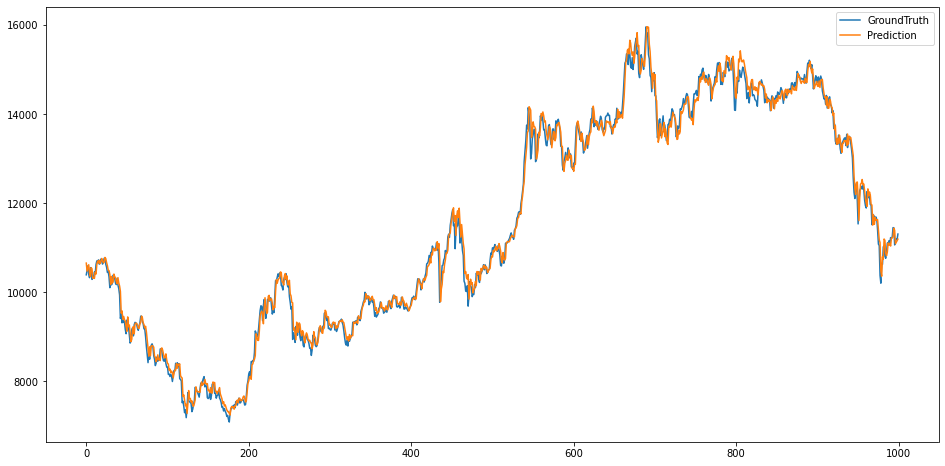

In [39]:
# # print(y_valid[0])
# # plt.figure(figsize=(16, 8))
# closing_price = closing_price.reshape(1,-1)
# y_valid = y_valid.reshape(1,-1)
# dict_data = {
#     'Predictions': closing_price[0],
#     'Close': y_valid[0],
# }
# data_pd = pd.DataFrame(dict_data)
# plt.figure(figsize=(16, 8))
# plt.plot(y_valid[0], label='GroundTruth')
# plt.plot(closing_price[0], label='Prediction')
# plt.savefig('./Baseline_result/SZ/result.png')
# plt.legend()
# # plt.plot(data_pd[['Close','Predictions']])
# # plt.plot(data_pd[['Predictions']])
# plt.show()
# # print(y_valid,closing_price)

In [13]:
!ls ./Baseline_result/

BiLSTM	    CNN-BiLSTM-AM  for_test  IXIC  SH	SZ
CNN-BiLSTM  CNN-LSTM	   HSI	     LSTM  SPX


In [118]:
# import numpy as np
# def MAPE(pred, true):
#     return np.mean(np.abs((pred - true) / true))
# def MAE(pred, true):
#     return np.mean(np.abs(pred - true))
# folder_path = './Ablation_result/Autoformer_lag_size_10/SH/'
# # np.save(folder_path + 'metrics.npy', np.array([mae, rms,R2]))
# # np.save(folder_path + 'pred.npy', closing_price
# preds = np.load(folder_path+'/pred.npy')
# trues = np.load(folder_path+'/true.npy')
# metrics = np.load(folder_path+'/metrics.npy')
# mape = MAPE(preds,trues)
# mae = MAE(preds,trues)
# print(preds.shape, trues.shape, metrics.shape)
# print(metrics)
# print(mape)
# print(mae)


# # prediction = np.load('./results/'+setting+'/real_prediction.npy')
# import matplotlib.pyplot as plt
# import matplotlib
# # print(prediction.shape)
# # print(prediction)
# import seaborn as sns
# plt.figure(figsize=(16, 8))
# # matplotlib.use('TKAgg')
# # plt.plot(prediction[:,:,-1],label='prediction')
# plt.plot(trues[:, -1], label='GroundTruth')
# plt.plot(preds[:, -1], label='Prediction')
# plt.savefig('./results/'+setting+'/result.png')
# plt.legend()
# plt.show()


(1000, 1, 1) (1000, 1, 1) (6,)
[2.27099838e+01 1.07799329e+03 3.28328094e+01 7.56923668e-03
 1.23805759e-04 9.80309978e-01]
0.007600347
22.709984
